### Installation des dépendances

In [1]:
%pip install numpy
%pip install opencv-python
%pip install -U matplotlib
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
import os
import time
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from einops import rearrange
from PIL import Image # Using here to convert openCV image to PIL image

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Define Constants
STEP_TO_NEXT_FRAME = 4 
""" in each video, we will read 1 frame every 24/STEP_TO_INDEX frames"""
DEBUG = False # if True, print debug information
NUMBER_OF_VIDEO = 100 # number of videos to index
MAX_FRAME_INDEXATION_TIME = 3 # in seconds
MAX_SEARCH_TIME = 0.1 # in seconds
VIDEOS_SIZE_ON_DISK = 444039168  # in octets
MAX_FRAME_NUMBER = 37895 # maximum number of frames in all video
N = int(MAX_FRAME_NUMBER/STEP_TO_NEXT_FRAME) # index Length
D = 128 # index Depth

In [13]:
#Define all global variables
imageList = []
videoList = []
frameIndexationTime = [] # Time must be in seconds
imageSearchTime = [] # Time must be in seconds
imageCompressionRateList = []
videoCompressionRateList = []
indexationTable = [] # Table of indexation
Descriptor_list = np.empty((N, D * 3), dtype=np.float32) # Descriptor of the image
resnet_descriptor = np.empty((N, D * 3), dtype=np.float32) # Descriptor of the image by resnet

### Lecture des fichiers

In [4]:
imagePath = "/data/jpeg/"
videoPath = "/data/mp4/"
currDirectory = os.getcwd()
imageList = os.listdir(currDirectory + imagePath)
videoList = os.listdir(currDirectory + videoPath)
# for file in imageList:
#     filePath = currDirectory + dataPath + file
#     img = cv.imread(filePath, cv.IMREAD_COLOR)

In [5]:
def getVideoParameter(videoPath:str):
    """return the frame rate and the number of frames of the video."""
    cap = cv2.VideoCapture(videoPath)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    return fps, frame_count
    

In [6]:
def displayRGBHistogram(histogram_r, histogram_g, histogram_b):
    plt.plot(histogram_b, color='blue', label='Canal bleu')
    plt.plot(histogram_g, color='green', label='Canal vert')
    plt.plot(histogram_r, color='red', label='Canal rouge')
    plt.xlabel('Intensité des pixels')
    plt.ylabel('Nombre de pixels')
    plt.title('Histogramme de l\'image')
    plt.legend()
    plt.show()

In [7]:

def convertImageToVector(imagePath, needToRead:bool = True):
    """return the histogram of the image."""
    if needToRead:
        image = cv2.imread(imagePath)
    else:
        image = imagePath

    #Separate the color channels
    canal_b = image[:, :, 0]
    canal_g = image[:, :, 1]
    canal_r = image[:, :, 2]

    # Calculate histograms for each channel
    # D means we will have 256/D values in the histogram
    histogram_b = cv2.calcHist([canal_b], [0], None, [D], [0, 256])
    histogram_g = cv2.calcHist([canal_g], [0], None, [D], [0, 256])
    histogram_r = cv2.calcHist([canal_r], [0], None, [D], [0, 256])
    
    vector_r = histogram_r.flatten()
    vector_g = histogram_g.flatten()
    vector_b = histogram_b.flatten()
    
    histogramme_complet = np.concatenate((vector_r, vector_g, vector_b))
    
    if DEBUG:
        displayRGBHistogram(histogram_r, histogram_g, histogram_b)

    return histogramme_complet

In [8]:
def cv2_to_pil(cv2_img):
    """Convert openCV image to PIL image to perfom resnet computing"""
    cv2_im_rgb = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(cv2_im_rgb)
    return pil_img

In [14]:
def ImageVectorResnet_CPU(imagePath, needToRead:bool = True):
    """Return resnet18 image descriptor"""
    if needToRead:
        image = cv2.imread(imagePath)
    else:
        image = imagePath
    
    new_image = cv2_to_pil(image)
    
    # Resnet-18 model loading
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)   # le modèle est chargé avec des poids pré-entrainés sur ImageNet
    model = torch.nn.Sequential(*(list(model.children())[:-1]))        # supprime la dernière couche du réseau
    model.eval();  
    
    
    # Pre-processing
    preprocess = transforms.Compose([
    transforms.Resize((224, 224)),                       
        transforms.ToTensor(),                            
        transforms.Normalize(mean=[0.485, 0.456, 0.406],    
                         std=[0.229, 0.224, 0.225]),
    ])
    
    input_tensor = preprocess(new_image)         # 3 x 224 x 224
    input_batch = input_tensor.unsqueeze(0)  # Ajout d'une dimension de batch : 1 x 3 x 224 x 224
    
    # Computing descriptor
    with torch.no_grad():
        output = model(input_batch)  # 1 x 512 x 1 x 1 


    output = rearrange(output, 'b d h w -> (b d h w)')  # 512
    output2_list = output.tolist()
    return output2_list

In [10]:
def plotingResnetDescriptor(descriptor:list, index_desc:int = 0):
    plt.plot(descriptor[index_desc])
    plt.title("Resnet descriptor")
    plt.show()

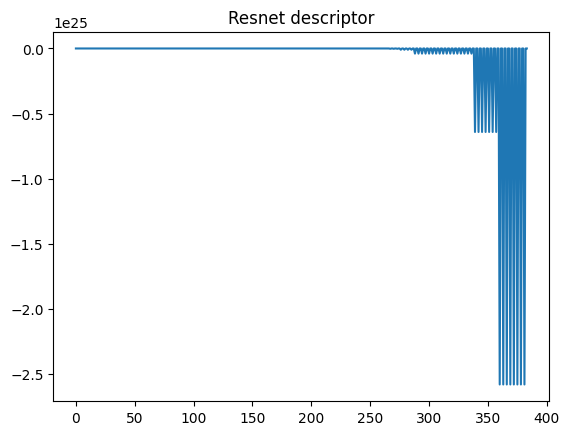

In [16]:
def createIndexTableResnet():
    """Index a video by creating a list of frames and their corresponding index. and update the indexationTable variable."""
    for video in videoList:
        path = currDirectory + videoPath + video
        fps, frame_count= getVideoParameter(path)
        cap = cv2.VideoCapture(path)
        startIndex = len(indexationTable)
        stopIndex = startIndex - 1 + math.floor(frame_count/STEP_TO_NEXT_FRAME)
        for i in range(startIndex, stopIndex):
            frameNumber = STEP_TO_NEXT_FRAME*(i-startIndex)
            indexationTable.append((frameNumber, video, (frameNumber/fps)))
            currImage = cap.set(cv2.CAP_PROP_POS_FRAMES, frameNumber)
            ret, currImage = cap.read()
            resnet_descriptor[i] = ImageVectorResnet_CPU(currImage, False)
            
 
createIndexTableResnet()       
plotingResnetDescriptor(resnet_descriptor, 1)

In [12]:
def createIndexTable():
    """Index a video by creating a list of frames and their corresponding index. and update the indexationTable variable."""
    for video in videoList:
        path = currDirectory + videoPath + video
        fps, frame_count= getVideoParameter(path)
        cap = cv2.VideoCapture(path)
        startIndex = len(indexationTable)
        stopIndex = startIndex - 1 + math.floor(frame_count/STEP_TO_NEXT_FRAME)
        for i in range(startIndex, stopIndex):
            frameNumber = STEP_TO_NEXT_FRAME*(i-startIndex)
            indexationTable.append((frameNumber, video, (frameNumber/fps)))
            currImage = cap.set(cv2.CAP_PROP_POS_FRAMES, frameNumber)
            ret, currImage = cap.read()
            Descriptor_list[i] = convertImageToVector(currImage, False)
        
createIndexTable()

In [ ]:
def CalculateCompressionRate():
    print(len(indexationTable))
    print(Descriptor_list.shape)
    rate = 1- (3*D*N*4)/VIDEOS_SIZE_ON_DISK #*4 because we use float32 and 3 because we have 3 channels RGB
    print(rate)
    
CalculateCompressionRate()

0
(9473, 384)
0.9672314312596856


In [ ]:
def videoCompressionRate(indexedVideo, video):

SyntaxError: incomplete input (2008863161.py, line 1)

In [ ]:
def imageCompressionRate(indexedImage, image):

In [ ]:
def writeSearchResults():
    

In [ ]:
def searchImage():
    

In [ ]:
def verifyFrameIndexationTime():
    """Function to verify if the indexation time of each frame is less than the max time allowed for indexation per frame."""
    videoToReindex = []
    totalIndexationTime = 0
    for i in range(0, len(frameIndexationTime)):
        totalIndexationTime += frameIndexationTime[i]
        if(frameIndexationTime[i] > MAX_FRAME_INDEXATION_TIME):
            videoToReindex.append(i)
    if len(videoToReindex) != 0:
        print("Les vidéos suivantes doivent être réindexées car elles prennent plus de temps que le temps maximal d'indexation par frame: " + str(MAX_FRAME_INDEXATION_TIME) + " secondes")
        for i in range(0, len(videoToReindex)):
            print(videoList[videoToReindex[i]])
    print("Toutes les vidéos ont été correctement indexées\nLe temps d'indexation total est: " + str(totalIndexationTime/60.0) + " minutes")


In [ ]:
def verifyImageSearchTime():
    """Function to verify if the search time for each image is less than the max time allowed for search per image."""
    imageToResearch = []
    totalSearchTime = 0
    for i in range(0, len(imageSearchTime)):
        totalSearchTime += imageSearchTime[i]
        if(imageSearchTime[i] > MAX_SEARCH_TIME):
            imageToResearch.append(i)
    if len(imageToResearch) != 0:
        print("La recherche doit être révisée pour les images suivantes car elles prennent plus de temps que le temps maximal de recherche par image: " + str(MAX_SEARCH_TIME) + " secondes")
        for i in range(0, len(imageToResearch)):
            print(imageList[imageToResearch[i]])
    print("Le temps de recherche total est: " + str(totalSearchTime) + " secondes")

In [ ]:
# Cell for test purposes
calculateTotalFrame()